# Cat vs Dog

In [ ]:
from google.colab import files
files.upload()
! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dogs-vs-cats
! unzip -qqo dogs-vs-cats.zip
! unzip -qqo test1.zip
! unzip -qqo train.zip

mv: cannot stat 'kaggle.json': No such file or directory
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
 for category in ("cat", "dog"):
  dir = new_base_dir / subset_name / category
  os.makedirs(dir, exist_ok = True)
  fnames = [f"{category}.{i}.jpg"
    for i in range(start_index, end_index)]
  for fname in fnames:
    shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=3000)
make_subset("test", start_index=3000, end_index=5000)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
import matplotlib.pyplot as plt

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
    ]
  )

def build_model(f1=16, f2=32, f3=64, f4=256, f5=128):
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=f1, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f2, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f3, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f4, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f5, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])
  return model

model = build_model()

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
 new_base_dir / "train",
 image_size=(180, 180),
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 new_base_dir / "validation",
 image_size=(180, 180),
 batch_size=32)
test_dataset = image_dataset_from_directory(
 new_base_dir / "test",
 image_size=(180, 180),
 batch_size=32)

Found 4000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch.keras",
 save_best_only=True,
 monitor="val_loss")
]

In [ ]:
if False:  # skip this for pre-loaded values
  histories = []
  params = []
  best_score = 0.0
  best_model = 0
  c = 0

  for f1 in [16, 32, 64]:
    for f2 in [32, 64, 128]:
      for f3 in [64, 128, 256]:
        for f4 in [128, 256, 512]:
          for f5 in [128, 256, 512, 1024]:
            params.append([f1, f2, f3, f4, f5])
            backend.clear_session()
            model = build_model(f1, f2, f3, f4, f5)
            histories.append(model.fit(
              train_dataset,
              epochs=25,
              validation_data=validation_dataset,
              callbacks=callbacks))
            s = model.evaluate(test_dataset, verbose=0)
            print(f"Model {c + 1}: loss={s[0]} accuracy={s[1]} params={params[c]}")
            if s[1] > best_score:
              best_score = s[1]
              best_model = c
            c += 1
else:
  histories = []
  params = [[16, 32, 64, 256, 128]]
  best_score = 0.0
  best_model = 0
  c = 0

In [ ]:
print(f"Best Model: model {best_model + 1}, accuracy={best_score}")
print(f"Params: {params[best_model]}")

Best Model: model 1, accuracy=0.0
Params: [16, 32, 64, 256, 128]


In [ ]:
backend.clear_session()

best_params = params[best_model]
model = build_model(best_params[0], best_params[1], best_params[2], best_params[3], best_params[4])

history = model.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 4s 25ms/step - loss: 0.6741 - accuracy: 0.5760 - val_loss: 0.6269 - val_accuracy: 0.6490
Epoch 2/30
125/125 [==============================] - 3s 24ms/step - loss: 0.6345 - accuracy: 0.6363 - val_loss: 0.6040 - val_accuracy: 0.6750
Epoch 3/30
125/125 [==============================] - 3s 24ms/step - loss: 0.5927 - accuracy: 0.6923 - val_loss: 0.5963 - val_accuracy: 0.6840
Epoch 4/30
125/125 [==============================] - 3s 25ms/step - loss: 0.5609 - accuracy: 0.7168 - val_loss: 0.5695 - val_accuracy: 0.7085
Epoch 5/30
125/125 [==============================] - 3s 24ms/step - loss: 0.5336 - accuracy: 0.7305 - val_loss: 0.5502 - val_accuracy: 0.7295
Epoch 6/30
125/125 [==============================] - 3s 25ms/step - loss: 0.5096 - accuracy: 0.7470 - val_loss: 0.5341 - val_accuracy: 0.7375
Epoch 7/30
125/125 [==============================] - 3s 24ms/step - loss: 0.4761 - accuracy: 0.7692 - val_loss: 0.7715 - val_accuracy: 0.5970

In [ ]:
s = model.evaluate(test_dataset, verbose=0)
print(f"Model {best_model + 1}: loss={s[0]} accuracy={s[1]} params={best_params}")

Model 1: loss=0.9155811667442322 accuracy=0.8199999928474426 params=[16, 32, 64, 256, 128]


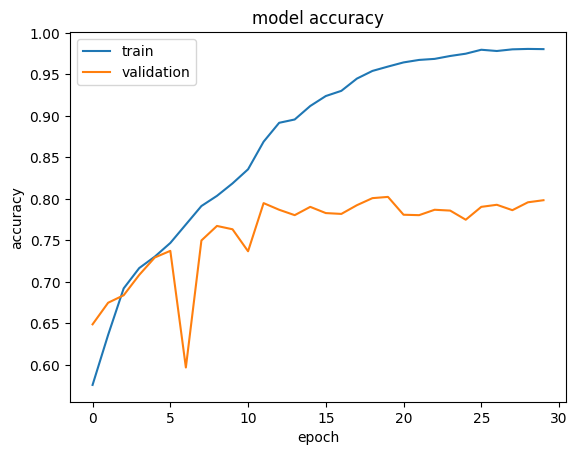

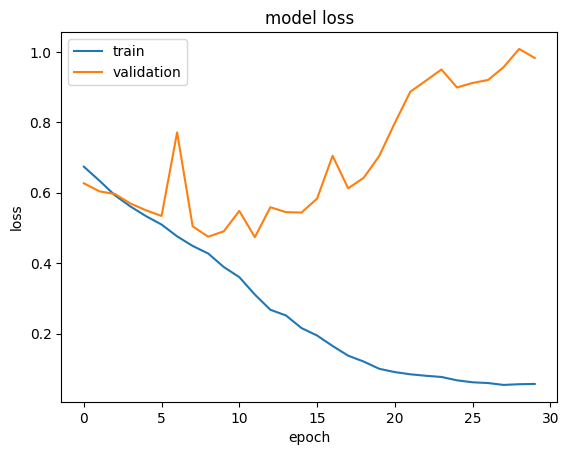

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Cassava Disease

In [ ]:
from google.colab import files
files.upload()
! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c cassava-disease

! unzip -qqo cassava-disease
! unzip -qqo train
! unzip -qqo test

mv: cannot stat 'kaggle.json': No such file or directory
cassava-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("plants_small")

def make_subset_plant(subset_name, start_index, end_index):
 for category in ("cbb", "cbsd", "cgm", "cmd", "healthy"):
  dir = new_base_dir / subset_name / category
  os.makedirs(dir, exist_ok = True)
  fnames = [f"train-{category}-{i}.jpg"
    for i in range(start_index, end_index)]
  for fname in fnames:
    shutil.copyfile(src=original_dir / category / fname, dst=dir / fname)

make_subset_plant("train", start_index=0, end_index=189)
make_subset_plant("validation", start_index=190, end_index=253)
make_subset_plant("test", start_index=253, end_index=316)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
 new_base_dir / "train",
 image_size=(180, 180),
 batch_size=32,
 label_mode="categorical").prefetch(2)
validation_dataset = image_dataset_from_directory(
 new_base_dir / "validation",
 image_size=(180, 180),
 batch_size=32,
 label_mode="categorical").prefetch(2)
test_dataset = image_dataset_from_directory(
 new_base_dir / "test",
 image_size=(180, 180),
 batch_size=32,
 label_mode="categorical",
 shuffle = False).prefetch(2)

Found 945 files belonging to 5 classes.
Found 315 files belonging to 5 classes.
Found 315 files belonging to 5 classes.


In [ ]:
train_size = 3959
test_size = 848

full_dataset = image_dataset_from_directory(
 original_dir,
 image_size=(180, 180),
 batch_size=1,
 label_mode="categorical",
 shuffle = False)
full_dataset = full_dataset.shuffle(5656, reshuffle_each_iteration=False)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
validation_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)
print(len(full_dataset))
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

In [ ]:
sums = [0, 0, 0, 0, 0]
for td in full_dataset:
  for data_point in td[1]:
    for i in range(0, 5):
      sums[i] += int(data_point[i])
print(sums)

sums = [0, 0, 0, 0, 0]
for td in train_dataset:
  for data_point in td[1]:
    for i in range(0, 5):
      sums[i] += int(data_point[i])
print(sums)

sums = [0, 0, 0, 0, 0]
for td in validation_dataset:
  for data_point in td[1]:
    for i in range(0, 5):
      sums[i] += int(data_point[i])
print(sums)

sums = [0, 0, 0, 0, 0]
for td in test_dataset:
  for data_point in td[1]:
    for i in range(0, 5):
      sums[i] += int(data_point[i])
print(sums)

[466, 1443, 773, 2658, 316]
[319, 1020, 531, 1880, 209]
[80, 199, 121, 379, 70]
[67, 224, 121, 399, 37]


In [ ]:
full_dataset = full_dataset.rebatch(32).prefetch(2)
train_dataset = train_dataset.rebatch(32).prefetch(62)
validation_dataset = validation_dataset.rebatch(32).prefetch(2)
test_dataset = test_dataset.rebatch(32).prefetch(2)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
import matplotlib.pyplot as plt
import gc

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch.keras",
 save_best_only=True,
 monitor="val_loss")
]

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
    ]
  )

def build_model(f1=16, f2=32, f3=256, f4=256, f5=1024):
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)
  x = layers.Rescaling(1./255)(x)
  x = layers.Conv2D(filters=f1, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f2, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f3, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f4, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=f5, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(5, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"])
  return model

In [ ]:
if False:  # skip this for pre-loaded values
  gc.collect()

  histories = []
  params = []
  best_score = 0.0
  best_model = 0
  c = 0

  for f1 in [16, 32, 64]:
    for f2 in [32, 64, 128]:
      for f3 in [64, 128, 256]:
        for f4 in [128, 256, 512]:
          for f5 in [128, 256, 512, 1024]:
            params.append([f1, f2, f3, f4, f5])
            backend.clear_session()
            gc.collect()
            model = build_model(f1, f2, f3, f4, f5)
            history = model.fit(
              train_dataset,
              epochs=15,
              validation_data=validation_dataset,
              callbacks=callbacks)
            #histories.append(history)
            s = model.evaluate(test_dataset, verbose=0)
            print(f"Model {c + 1}: loss={s[0]} accuracy={s[1]} params={params[c]}")
            if s[1] > best_score:
              best_score = s[1]
              best_model = c
            c += 1
else:
  histories = []
  params = [[16, 32, 256, 256, 1024]]
  best_score = 0.0
  best_model = 0

In [ ]:
print(f"Best Model: model {best_model + 1}, accuracy={best_score}")
print(f"Params: {params[best_model]}")

Best Model: model 1, accuracy=0.0
Params: [16, 32, 256, 256, 1024]


In [ ]:
backend.clear_session()

best_params = params[best_model]
model = build_model(best_params[0], best_params[1], best_params[2], best_params[3], best_params[4])

history = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
30/30 [==============================] - 3s 47ms/step - loss: 1.6230 - accuracy: 0.2063 - val_loss: 1.6074 - val_accuracy: 0.2000
Epoch 2/50
30/30 [==============================] - 1s 40ms/step - loss: 1.6111 - accuracy: 0.1873 - val_loss: 1.6089 - val_accuracy: 0.2063
Epoch 3/50
30/30 [==============================] - 1s 42ms/step - loss: 1.6083 - accuracy: 0.2212 - val_loss: 1.6005 - val_accuracy: 0.3016
Epoch 4/50
30/30 [==============================] - 1s 41ms/step - loss: 1.5882 - accuracy: 0.2402 - val_loss: 1.6054 - val_accuracy: 0.2159
Epoch 5/50
30/30 [==============================] - 1s 41ms/step - loss: 1.6066 - accuracy: 0.2243 - val_loss: 1.6029 - val_accuracy: 0.2571
Epoch 6/50
30/30 [==============================] - 1s 43ms/step - loss: 1.5730 - accuracy: 0.2487 - val_loss: 1.5465 - val_accuracy: 0.2635
Epoch 7/50
30/30 [==============================] - 1s 40ms/step - loss: 1.5957 - accuracy: 0.2201 - val_loss: 1.5774 - val_accuracy: 0.1873
Epoch 8/50
30

In [ ]:
s = model.evaluate(test_dataset, verbose=0)
print(f"Model {best_model + 1}: loss={s[0]} accuracy={s[1]} params={best_params}")

Model 1: loss=1.4305710792541504 accuracy=0.3841269910335541 params=[16, 32, 256, 256, 1024]


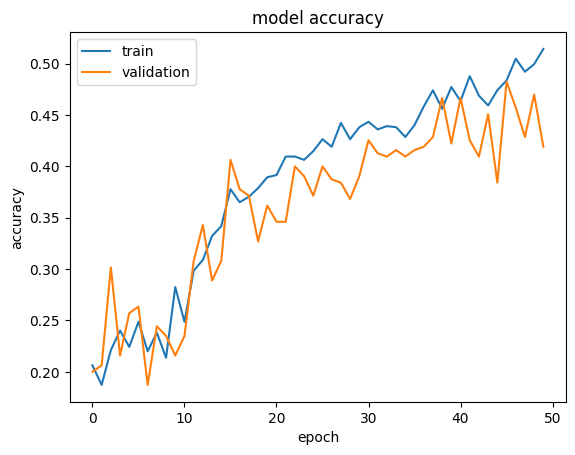

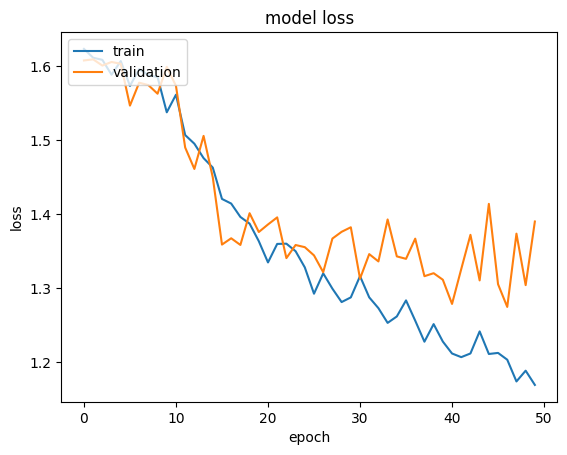

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
ds = (test_dataset)
real = np.concatenate([y for x, y in ds], axis=0)
pred = model.predict(ds)
print(classification_report(np.argmax(real, axis=1), np.argmax(pred, axis=1)))
print(accuracy_score(np.argmax(real, axis=1), np.argmax(pred, axis=1)))


10/10 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.58      0.29      0.38        63
           1       0.47      0.29      0.36        63
           2       0.11      0.06      0.08        63
           3       0.32      0.81      0.46        63
           4       0.59      0.48      0.53        63

    accuracy                           0.38       315
   macro avg       0.41      0.38      0.36       315
weighted avg       0.41      0.38      0.36       315

0.38412698412698415
